## Setup

In [27]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pickle as pkl
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils
import brain_observatory_utilities.datasets.electrophysiology.utilities as ephys_utils

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

import matplotlib
import matplotlib.animation as animation
import matplotlib.patches as patches

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic functions for jupyter notebook plotting
%matplotlib inline

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [3]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

In [4]:
# file paths
recording_type = 'ephys'
postproc_dir = '/root/capsule/postprocessed/'+recording_type+'/'
fig_dir = '/root/capsule/figures/'+recording_type+'/'

# plotting
cpal = sns.color_palette('Grays')
colors = {'F':cpal[2], 'N':cpal[5],
          'ff':'k', 'fn':'dodgerblue', 'nf':'gray', 'nn':'fuchsia',
          'hit':'limegreen', 'miss':'k',
          'vip':'blueviolet', 'non':'k'}

In [5]:
# get the metadata tables
# units_table = cache.get_unit_table()
# channels_table = cache.get_channel_table()
# probes_table = cache.get_probe_table()
# behavior_sessions_table = cache.get_behavior_session_table()
ecephys_sessions_table = cache.get_ecephys_session_table()

In [6]:
# load optotagged units & channels table
filename = 'NewThreshold_VIP_AllSessions_unit_channel_merge_table_optotag_7ms_delta8Hz_Novel_2024_08_30_03_11_29'
vip_units_table = pd.read_csv(postproc_dir+filename+'.csv')
vip_units_table = vip_units_table.drop(columns=['Unnamed: 0.1','Unnamed: 0']) # units and channels

## Load data

In [96]:
session_id = 1052533639
session = cache.get_ecephys_session(ecephys_session_id=session_id)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [97]:
# load neural data
spike_times = session.spike_times

# load behavioral data
all_stim_pres = session.stimulus_presentations
stim_pres = behavior_utils.get_annotated_stimulus_presentations(session) # only image presentations in stim block 0 - why?

/opt/conda/lib/python3.10/site-packages/brain_observatory_utilities/datasets/behavior/data_formatting.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['change_trials_id'] = trials.index.values


In [98]:
# get unit and channel data, sort the units by depth and filter for "good" units
units = session.get_units() # contains information about spike waveforms, isolation quality
channels = session.get_channels() # contains information about anatomical location

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True) # associate anatomical information with each unit

# sort units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

# filter units using QC metrics
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<.5)&
                    (unit_channels['firing_rate']>0.1)&
                    (unit_channels['amplitude_cutoff']<0.1)&
                    (unit_channels['presence_ratio']>.9)
                   )

good_units = unit_channels.loc[good_unit_filter]

# filter by brain region
area_of_interest = 'VIS'
area_units = good_units[good_units['structure_acronym'].str.contains(area_of_interest)]
# area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)
print(num_units)

348


In [99]:
# get vip units for this session
vip_units = vip_units_table[(vip_units_table.NEW_putative_cellType=='likely_VIP') & (vip_units_table.session_id==session_id)]

# add column in area_units for vip identity
is_vip = np.isin(area_units.index, vip_units.unit_id)
area_units['is_vip'] = is_vip.tolist()
print(area_units['is_vip'].sum())

35


/tmp/ipykernel_2249/685038419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_units['is_vip'] = is_vip.tolist()


## PCA on entire block - time across session x unit

In [100]:
# get binned spike rates
bin_size = 0.04 # seconds
spike_rate_df, timestamps = ephys_utils.get_continous_spike_rate_for_units(session, spike_rate_bin_size=bin_size, stimulus_block=0)

(90195, 348)
(90195, 348)


PCA(n_components=348)

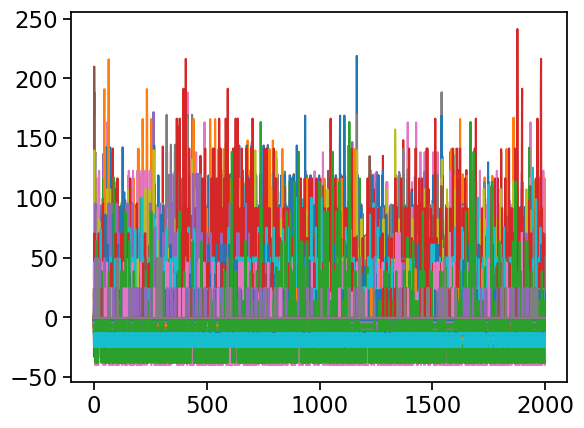

In [101]:
# create matrix of samples x features
area_units_spike_rate_df = spike_rate_df.loc[area_units.index]
binned_spikes = np.array([area_units_spike_rate_df.iloc[i].values[0] for i in range(num_units)]).T
print(binned_spikes.shape)

# de-mean data
X = binned_spikes - binned_spikes.mean(axis=0)
print(X.shape)

plt.plot(X[:2000,])

# perform PCA
pca = PCA(n_components=num_units)
pca.fit(X)

0.33319725891902796


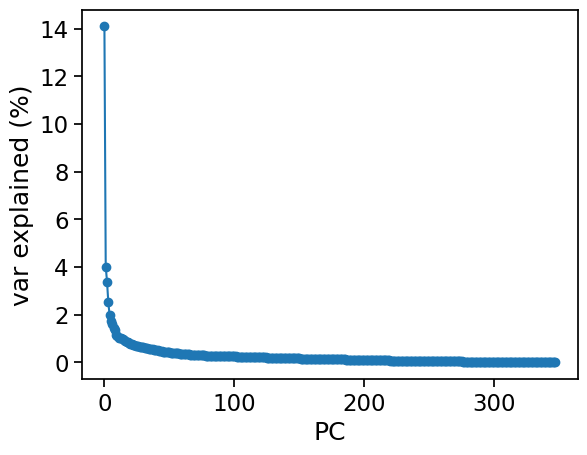

In [102]:
# visualize variance explained by PCs
plt.plot(pca.explained_variance_ratio_*100, 'o-')
plt.xlabel('PC')
plt.ylabel('var explained (%)')

# variance explained by top PCs
latent_dim = 10
latent_space = pca.components_[:latent_dim]
print(pca.explained_variance_ratio_[:latent_dim].sum())

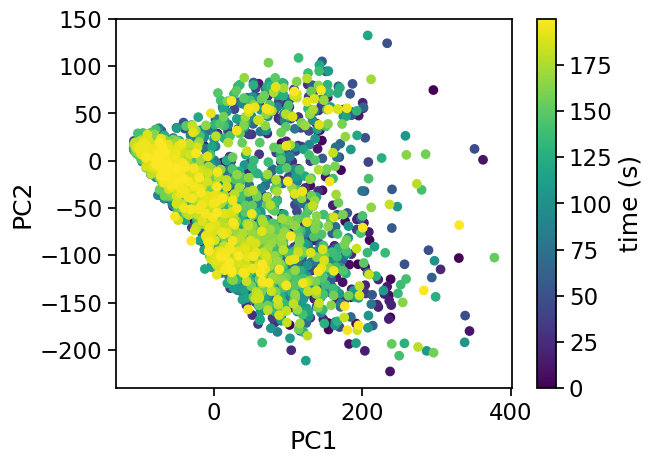

In [103]:
# project data onto top PCs
binned_spikes_proj = pca.fit_transform(X) # samples x components

t = 5000
plt.scatter(binned_spikes_proj[:t,0], binned_spikes_proj[:t,1], c=timestamps[:t])
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('time (s)')

## PCA on time window around image change - time within trial x unit

In [104]:
# helper functions for binning spike counts into rates
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    if ~isinstance(startTimes, list) and ~isinstance(startTimes, np.ndarray):
        startTimes = np.array(startTimes, ndmin=1)
    
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

def makePSTH_wrapper(area_units, spike_times, all_event_times, event_idx_to_use, time_before, time_after, bin_size=0.04):
    event_responses = []
    event_times = all_event_times[event_idx_to_use]
    
    for iu, unit in area_units.iterrows():
        unit_response, bins = makePSTH(spike_times[iu], event_times-time_before, time_before+time_after, bin_size)
        event_responses.append(unit_response)
        
    return np.array(event_responses), bins

subdivide all trials where is_change True:

F-F: previous trial's is_image_novel False, is_image_novel False

F-N: previous trial's is_image_novel False, is_image_novel True

N-F: previous trial's is_image_novel True, is_image_novel False

N-N: previous trial's is_image_novel True, is_image_novel True

In [105]:
# create df with all image change trials 
change_trial_df = stim_pres[stim_pres['is_change']]
preceding_trial_idx = change_trial_df.index-1 # index is stimulus_presentations_id

# before & after image are both novel 
nn_idx = np.where(stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & change_trial_df['is_image_novel'].values)[0]

# before & after image are both familiar
ff_idx = np.where(~stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & ~change_trial_df['is_image_novel'].values)[0]

# before image is novel, after image is familiar
nf_idx = np.where(stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & ~change_trial_df['is_image_novel'].values)[0]

# before image is familiar, after image is novel
fn_idx = np.where(~stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & change_trial_df['is_image_novel'].values)[0]

print(len(nn_idx), len(ff_idx), len(nf_idx), len(fn_idx))

150 10 60 60


In [106]:
# align data to image change, for each condition
spike_times = session.spike_times
all_event_times = change_trial_df.start_time.values
time_before = 1
time_after = .75
bin_size = 0.04

# get trial-averaged response per unit to each image change condition
nn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, nn_idx, time_before, time_after, bin_size=bin_size)
ff_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, ff_idx, time_before, time_after, bin_size=bin_size)
nf_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, nf_idx, time_before, time_after, bin_size=bin_size)
fn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, fn_idx, time_before, time_after, bin_size=bin_size)

### Response by condition

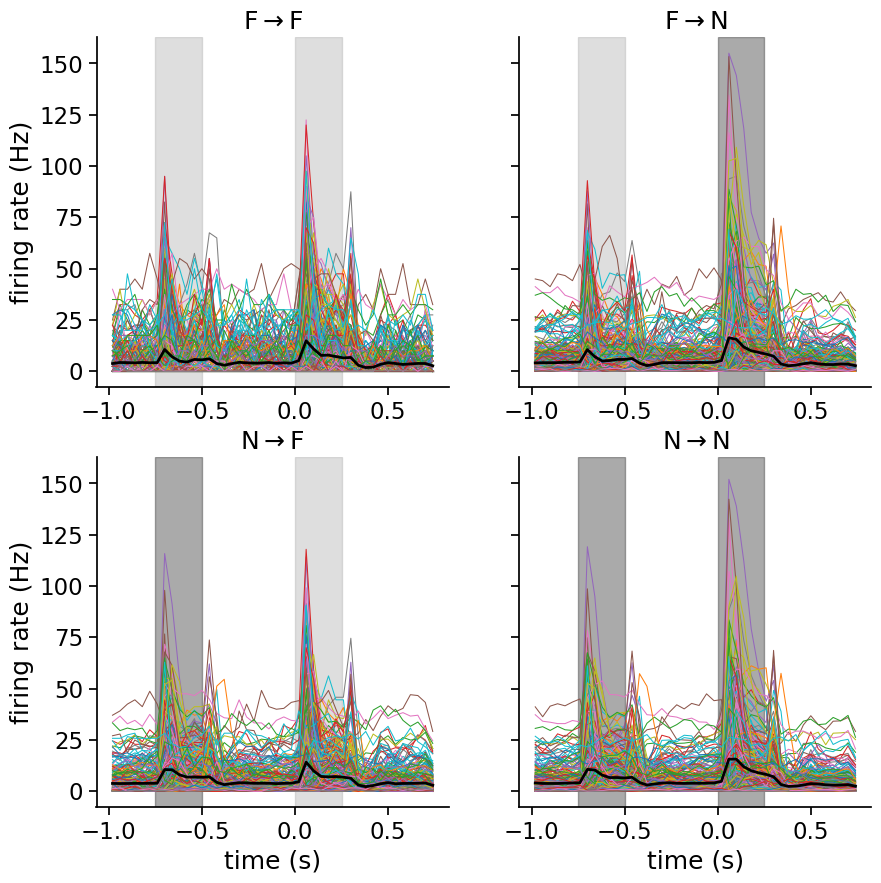

In [107]:
# plot trial-averaged unit responses to each image change condition
w_unit = .75
w_avg = 2
w_vert = 1
a = .4
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True)
for i in range(2):
    for j in range(2):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
# shade image on periods
ax[0,0].axvspan(-.75, -.5, alpha=a, color=colors['F'], zorder=0)
ax[0,1].axvspan(-.75, -.5, alpha=a, color=colors['F'], zorder=0)
ax[0,0].axvspan(0, .25, alpha=a, color=colors['F'], zorder=0)
ax[1,0].axvspan(0, .25, alpha=a, color=colors['F'], zorder=0)
ax[1,0].axvspan(-.75, -.5, alpha=a, color=colors['N'], zorder=0)
ax[1,1].axvspan(-.75, -.5, alpha=a, color=colors['N'], zorder=0)
ax[0,1].axvspan(0, .25, alpha=a, color=colors['N'], zorder=0)
ax[1,1].axvspan(0, .25, alpha=a, color=colors['N'], zorder=0)
        
time_bins = np.arange(-time_before, time_after, bin_size)+bin_size/2

ax[0,0].set_title(r'F$\rightarrow$F')
ax[0,0].plot(time_bins, ff_responses.T, linewidth=w_unit)
ax[0,0].plot(time_bins, ff_responses.mean(axis=0), 'k', linewidth=w_avg)

ax[0,1].set_title(r'F$\rightarrow$N')
ax[0,1].plot(time_bins, fn_responses.T, linewidth=w_unit)
ax[0,1].plot(time_bins, fn_responses.mean(axis=0), 'k', linewidth=w_avg)

ax[1,0].set_title(r'N$\rightarrow$F')
ax[1,0].plot(time_bins, nf_responses.T, linewidth=w_unit)
ax[1,0].plot(time_bins, nf_responses.mean(axis=0), 'k', linewidth=w_avg)

ax[1,1].set_title(r'N$\rightarrow$N')
ax[1,1].plot(time_bins, nn_responses.T, linewidth=w_unit)
ax[1,1].plot(time_bins, nn_responses.mean(axis=0), 'k', linewidth=w_avg)

ax[0,0].set_ylabel('firing rate (Hz)')
ax[1,0].set_ylabel('firing rate (Hz)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')

filename = f"erp_trialavg_percondition_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

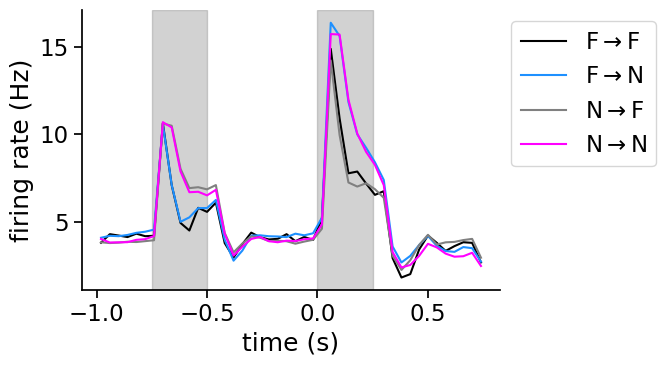

In [108]:
# plot mean of trial-averaged unit responses to each image change condition
w_avg = 1.5
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
        
time_bins = np.arange(-time_before, time_after, bin_size)+bin_size/2

ax.plot(time_bins, ff_responses.mean(axis=0), colors['ff'], linewidth=w_avg, label=r'F$\rightarrow$F')
ax.plot(time_bins, fn_responses.mean(axis=0), colors['fn'], linewidth=w_avg, label=r'F$\rightarrow$N')
ax.plot(time_bins, nf_responses.mean(axis=0), colors['nf'], linewidth=w_avg, label=r'N$\rightarrow$F')
ax.plot(time_bins, nn_responses.mean(axis=0), colors['nn'], linewidth=w_avg, label=r'N$\rightarrow$N')

# shade image on periods
ax.axvspan(-.75, -.5, alpha=.35, color='gray', zorder=0)
ax.axvspan(0, .25, alpha=.35, color='gray', zorder=0)

ax.set_xlabel('time (s)')
ax.set_ylabel('firing rate (Hz)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()

filename = f"erp_trialavg_allcondition_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

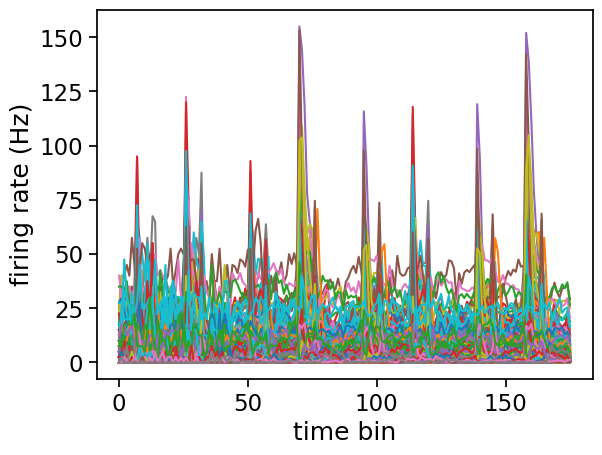

In [109]:
# concatenate image change conditions together
concat_responses = np.hstack([ff_responses,fn_responses,nf_responses,nn_responses])
timestamps = np.arange(concat_responses.shape[1])
plt.plot(concat_responses.T)
plt.xlabel('time bin')
plt.ylabel('firing rate (Hz)');

### PCA

(176, 348)


PCA(n_components=176)

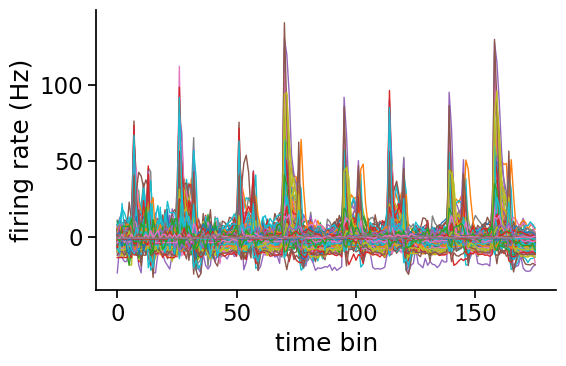

In [110]:
# create de-meaned matrix of samples x features
X = concat_responses.T - concat_responses.T.mean(axis=0)
print(X.shape)

# plot data (each unit is a different color)
w_unit = 1
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(X, linewidth=w_unit)
plt.xlabel('time bin')
plt.ylabel('firing rate (Hz)')
plt.tight_layout()

filename = f"pca_trialavg_input_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

# perform PCA
pca = PCA(n_components=min(num_units,X.shape[0]))
pca.fit(X)

0.9080546709204994


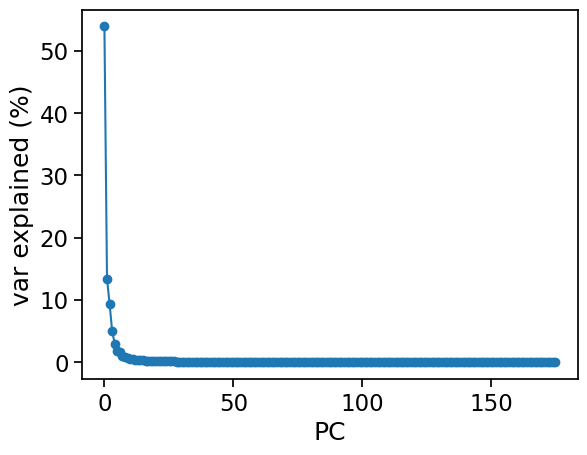

In [111]:
# visualize variance explained by PCs
plt.plot(pca.explained_variance_ratio_*100, 'o-')
plt.xlabel('PC')
plt.ylabel('var explained (%)')

# variance explained by top PCs
latent_dim = 10
latent_space = pca.components_[:latent_dim]
print(pca.explained_variance_ratio_[:latent_dim].sum())

### Projection 2d

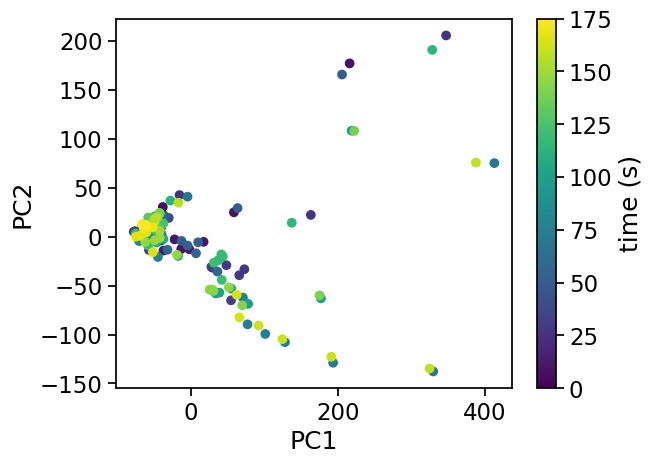

In [112]:
# project data onto top PCs
concat_responses_proj = pca.fit_transform(X) # samples x components

t = len(timestamps)
plt.scatter(concat_responses_proj[:t,0], concat_responses_proj[:t,1], c=timestamps[:t])
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('time (s)')

In [113]:
# project responses to each condition onto top PCs
ff_responses_proj = pca.transform(ff_responses.T - concat_responses.T.mean(axis=0)) # input should be samples x features
fn_responses_proj = pca.transform(fn_responses.T - concat_responses.T.mean(axis=0))
nf_responses_proj = pca.transform(nf_responses.T - concat_responses.T.mean(axis=0))
nn_responses_proj = pca.transform(nn_responses.T - concat_responses.T.mean(axis=0))

# save PCA inputs, model, and projections
results_dict = dict(concat_responses=concat_responses, ff_responses=ff_responses, nf_responses=nf_responses, nn_responses=nn_responses, # not de-meaned
                    X=X, pca=pca, # input to model: demeaned version of concat_responses, fit model
                    concat_responses_proj=concat_responses_proj, ff_responses_proj=ff_responses_proj, # de-meaned wrt concat_responses, then projected
                    fn_responses_proj=fn_responses_proj, nf_responses_proj=nf_responses_proj, nn_responses_proj=nn_responses_proj
                   )

filename = f"{recording_type}_pca_trialavg_{session_id}_{area_of_interest}"
pkl.dump(results_dict, open(postproc_dir+filename+'.pkl', "wb"))

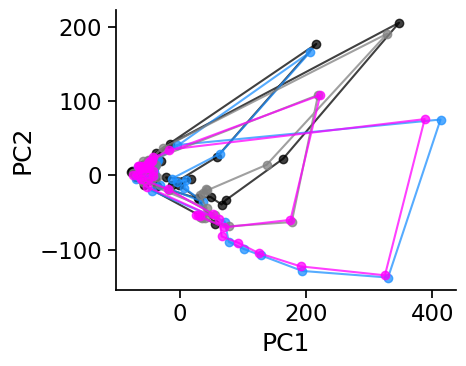

In [114]:
# project responses to each condition onto top PCs
a = .75
m = 'o-'
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc_idx_x = 0
pc_idx_y = 1

ax.plot(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
ax.plot(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')
plt.xlabel(f'PC{pc_idx_x+1}')
plt.ylabel(f'PC{pc_idx_y+1}')
# plt.legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()

ax_lims = [ax.get_xlim(), ax.get_ylim()]
filename = f"pca_trialavg_proj_{pc_idx_x+1}v{pc_idx_y+1}_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

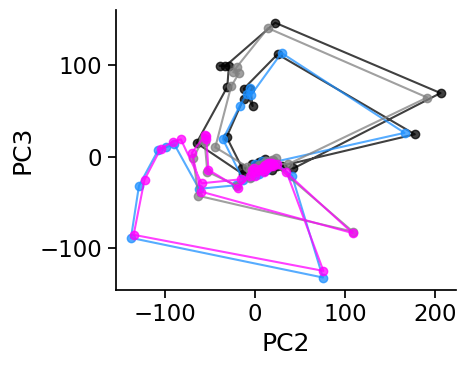

In [115]:
# project responses to each condition onto top PCs
a = .75
m = 'o-'
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc_idx_x = 1
pc_idx_y = 2

ax.plot(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
ax.plot(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')
plt.xlabel(f'PC{pc_idx_x+1}')
plt.ylabel(f'PC{pc_idx_y+1}')
# plt.legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()

ax_lims.append(ax.get_ylim())
filename = f"pca_trialavg_proj_{pc_idx_x+1}v{pc_idx_y+1}_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

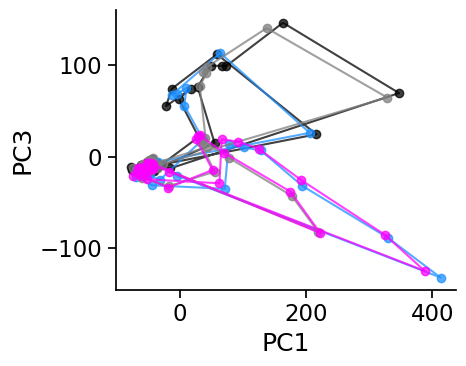

In [116]:
# project responses to each condition onto top PCs
a = .75
m = 'o-'
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc_idx_x = 0
pc_idx_y = 2

ax.plot(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
ax.plot(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')
plt.xlabel(f'PC{pc_idx_x+1}')
plt.ylabel(f'PC{pc_idx_y+1}')
# plt.legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()

filename = f"pca_trialavg_proj_{pc_idx_x+1}v{pc_idx_y+1}_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

### Projection 3d

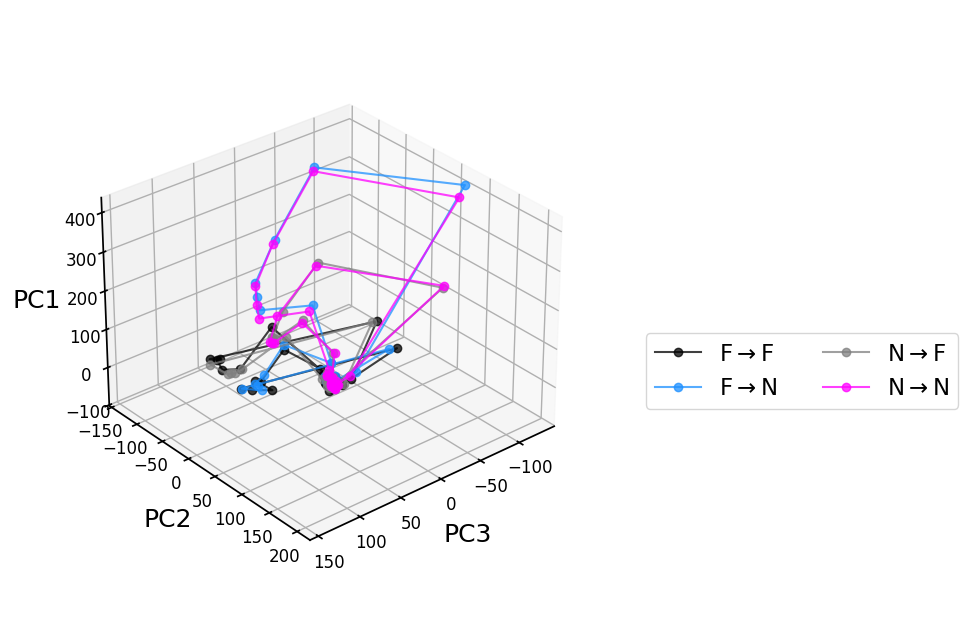

In [117]:
a = .75
m = 'o-'
lp = 15
sz = 12
elev_start = 30
azim_start = 50
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':'3d'})
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

ax.plot(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], ff_responses_proj[:,pc_idx_z], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], fn_responses_proj[:,pc_idx_z], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
ax.plot(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], nf_responses_proj[:,pc_idx_z], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], nn_responses_proj[:,pc_idx_z], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')

ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
plt.legend(ncols=2, bbox_to_anchor=(1,.5), loc='upper left')
plt.tight_layout()

filename = f"pca_trialavg_3dproj_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

### Projection animation 2d

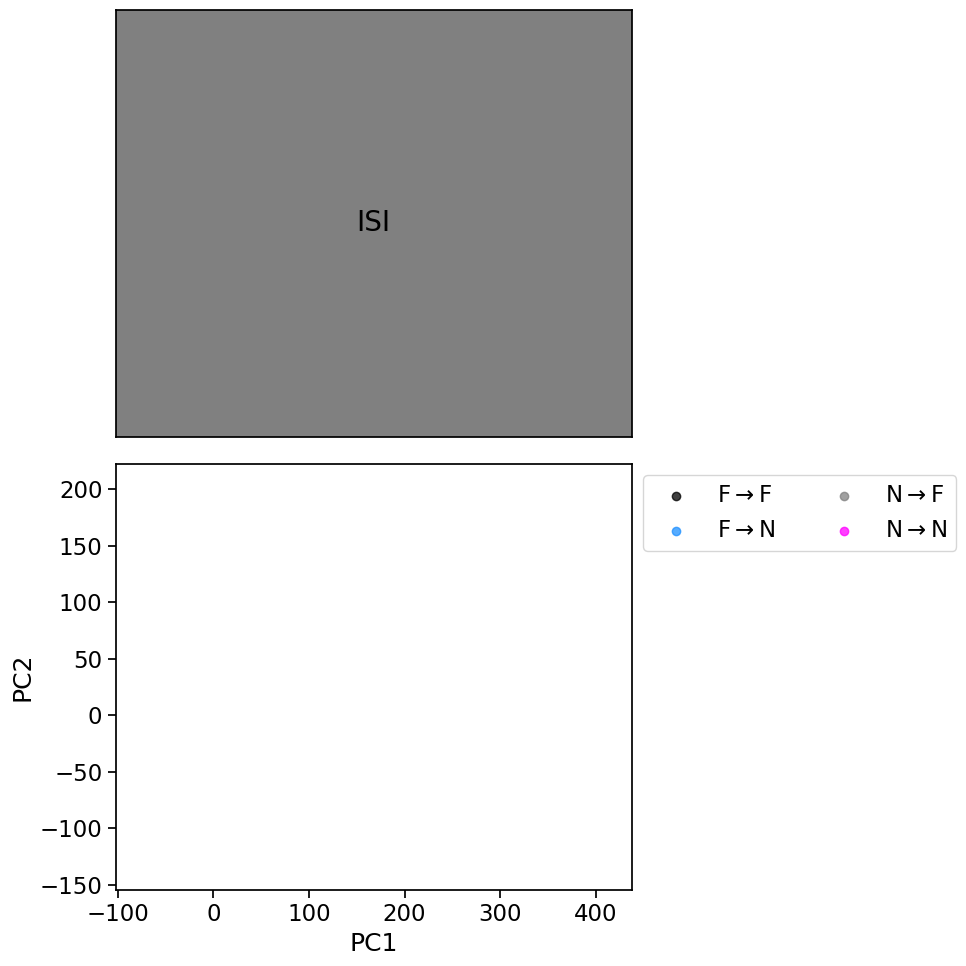

In [118]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
pc_idx_x = 0
pc_idx_y = 1

# create flash for image change
prev_on_idx = np.searchsorted(time_bins, -0.75)
prev_off_idx = np.searchsorted(time_bins[prev_on_idx:], -0.5)
on_idx = np.searchsorted(time_bins[prev_on_idx+prev_off_idx:], 0)
off_idx = np.searchsorted(time_bins[prev_on_idx+prev_off_idx+on_idx:], 0.25)
end_idx = len(time_bins[prev_on_idx+prev_off_idx+on_idx+off_idx:])
patch_color = np.concatenate((
    np.repeat('gray', 1), # init frame
    np.repeat('gray', prev_on_idx), # gray screen
    np.repeat('limegreen', prev_off_idx), # image on
    np.repeat('gray', on_idx), # gray screen
    np.repeat('limegreen', off_idx), # image on
    np.repeat('gray', end_idx) # gray screen
))

# create labels for image change
labels = np.concatenate((
    np.repeat('ISI', 1), # init frame
    np.repeat('ISI', prev_on_idx), # gray screen
    np.repeat('IMAGE ON', prev_off_idx), # image on
    np.repeat('ISI', on_idx), # gray screen
    np.repeat('IMAGE ON', off_idx), # image on
    np.repeat('ISI', end_idx) # gray screen
))
time_labels = [''] + ['t= '+str(np.round(i,2))+'s' for i in time_bins]

# scatter plots
ff_scat = ax[1].scatter(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
fn_scat = ax[1].scatter(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
nf_scat = ax[1].scatter(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
nn_scat = ax[1].scatter(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')

# line plots
ff_line = ax[1].plot(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], c=colors['ff'], alpha=a)[0]
fn_line = ax[1].plot(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], c=colors['fn'], alpha=a)[0]
nf_line = ax[1].plot(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], c=colors['nf'], alpha=a)[0]
nn_line = ax[1].plot(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], c=colors['nn'], alpha=a)[0]

# rectangle
patch = patches.Rectangle((0, 0), 1, 1, facecolor=patch_color[0], fill=True)
ax[0].add_patch(patch)

# text
txt = ax[0].text(.5, .5, '', fontsize=20, verticalalignment='center', horizontalalignment='center')
time_txt = ax[0].text(.5, .4, '', fontsize=16, verticalalignment='center', horizontalalignment='center')

ax[1].set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}')
leg = ax[1].legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
ax[0].set(xlim=(0,1), ylim=(0,1), xlabel='', ylabel='', xticks=[], yticks=[])

def update(frame):
    # update scatter plots
    ff_scat.set_offsets( np.stack([ff_responses_proj[:frame,pc_idx_x], ff_responses_proj[:frame,pc_idx_y]]).T )
    fn_scat.set_offsets( np.stack([fn_responses_proj[:frame,pc_idx_x], fn_responses_proj[:frame,pc_idx_y]]).T )
    nf_scat.set_offsets( np.stack([nf_responses_proj[:frame,pc_idx_x], nf_responses_proj[:frame,pc_idx_y]]).T )
    nn_scat.set_offsets( np.stack([nn_responses_proj[:frame,pc_idx_x], nn_responses_proj[:frame,pc_idx_y]]).T )
    
    # update line plots
    ff_line.set_xdata(ff_responses_proj[:frame,pc_idx_x]); ff_line.set_ydata(ff_responses_proj[:frame,pc_idx_y])
    fn_line.set_xdata(fn_responses_proj[:frame,pc_idx_x]); fn_line.set_ydata(fn_responses_proj[:frame,pc_idx_y])
    nf_line.set_xdata(nf_responses_proj[:frame,pc_idx_x]); nf_line.set_ydata(nf_responses_proj[:frame,pc_idx_y])
    nn_line.set_xdata(nn_responses_proj[:frame,pc_idx_x]); nn_line.set_ydata(nn_responses_proj[:frame,pc_idx_y])
    
    # update rectangle
    patch.set_facecolor(patch_color[frame])
    
    # update text
    txt.set_text(labels[frame])
    time_txt.set_text(time_labels[frame])
    
    # # keep legend consistent
    leg.set_ncols(2)
    leg.set_bbox_to_anchor((1,1))
    leg.set_loc('upper left')

    return fig

n_frames = len(time_bins)+1
isi = 750 # in ms
ani = animation.FuncAnimation(fig=fig, func=update, frames=n_frames, interval=isi)
plt.tight_layout()

filename = f"pca_trialavg_proj_{session_id}_{area_of_interest}"
ani.save(fig_dir+filename+'.gif', writer="pillow")

### Projection animation 3d

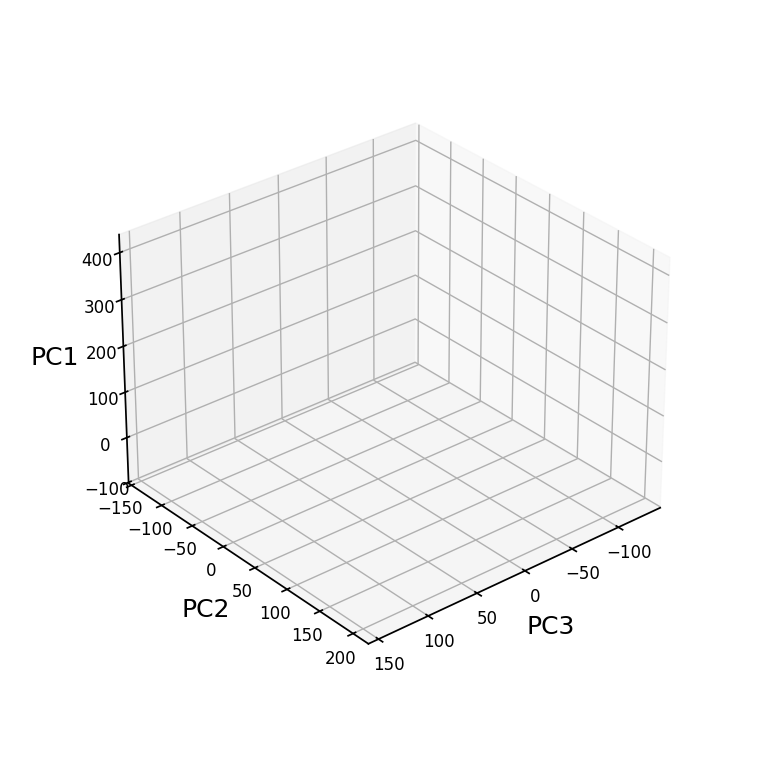

In [119]:
lp = 15
sz = 12
elev_start = 30
azim_start = 50
fig, ax = plt.subplots(1,1, figsize=(8,8), subplot_kw={'projection':'3d'})
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

# scatter plots
ff_scat = ax.scatter(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
fn_scat = ax.scatter(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], fn_responses_proj[0,pc_idx_z], c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
nf_scat = ax.scatter(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], nf_responses_proj[0,pc_idx_z], c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
nn_scat = ax.scatter(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], nn_responses_proj[0,pc_idx_z], c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')

# line plots
ff_line = ax.plot(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['ff'], alpha=a)[0]
fn_line = ax.plot(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['fn'], alpha=a)[0]
nf_line = ax.plot(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['nf'], alpha=a)[0]
nn_line = ax.plot(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['nn'], alpha=a)[0]

# # rectangle
# patch = patches.Rectangle((0, 0), 1, 1, facecolor=patch_color[0], fill=True)
# ax[0].add_patch(patch)

# # text
# txt = ax[0].text(.5, .5, '', fontsize=20, verticalalignment='center', horizontalalignment='center')
# time_txt = ax[0].text(.5, .4, '', fontsize=16, verticalalignment='center', horizontalalignment='center')

ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
# leg = ax[1].legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
# ax[0].set(xlim=(0,1), ylim=(0,1), xlabel='', ylabel='', xticks=[], yticks=[])

def update(frame):
    # update scatter plots
    ff_scat._offsets3d = ( ff_responses_proj[:frame,pc_idx_x], ff_responses_proj[:frame,pc_idx_y], ff_responses_proj[:frame,pc_idx_z] )
    fn_scat._offsets3d = ( fn_responses_proj[:frame,pc_idx_x], fn_responses_proj[:frame,pc_idx_y], fn_responses_proj[:frame,pc_idx_z] )
    nf_scat._offsets3d = ( nf_responses_proj[:frame,pc_idx_x], nf_responses_proj[:frame,pc_idx_y], nf_responses_proj[:frame,pc_idx_z] )
    nn_scat._offsets3d = ( nn_responses_proj[:frame,pc_idx_x], nn_responses_proj[:frame,pc_idx_y], nn_responses_proj[:frame,pc_idx_z] )
    
    # update line plots   
    ff_line.set_data_3d(ff_responses_proj[:frame,pc_idx_x], ff_responses_proj[:frame,pc_idx_y], ff_responses_proj[:frame,pc_idx_z])
    fn_line.set_data_3d(fn_responses_proj[:frame,pc_idx_x], fn_responses_proj[:frame,pc_idx_y], fn_responses_proj[:frame,pc_idx_z])
    nf_line.set_data_3d(nf_responses_proj[:frame,pc_idx_x], nf_responses_proj[:frame,pc_idx_y], nf_responses_proj[:frame,pc_idx_z])
    nn_line.set_data_3d(nn_responses_proj[:frame,pc_idx_x], nn_responses_proj[:frame,pc_idx_y], nn_responses_proj[:frame,pc_idx_z])

    elev = elev_start + 30 * np.sin(2 * np.pi * frame / 360)
    azim = azim_start + 360 * frame / 360  # full 360 degree rotation
    ax.view_init(elev=elev_start, azim=azim_start)
    
#     # update rectangle
#     patch.set_facecolor(patch_color[frame])
    
#     # update text
#     txt.set_text(labels[frame])
#     time_txt.set_text(time_labels[frame])
    
#     # # keep legend consistent
#     leg.set_ncols(2)
#     leg.set_bbox_to_anchor((1,1))
#     leg.set_loc('upper left')

    return fig

n_frames = len(time_bins)+1
isi = 750 # in ms
ani = animation.FuncAnimation(fig=fig, func=update, frames=n_frames, interval=isi)
plt.tight_layout()

filename = f"pca_trialavg_3dproj_noscreen_{session_id}_{area_of_interest}"
ani.save(fig_dir+filename+'.gif', writer="pillow")

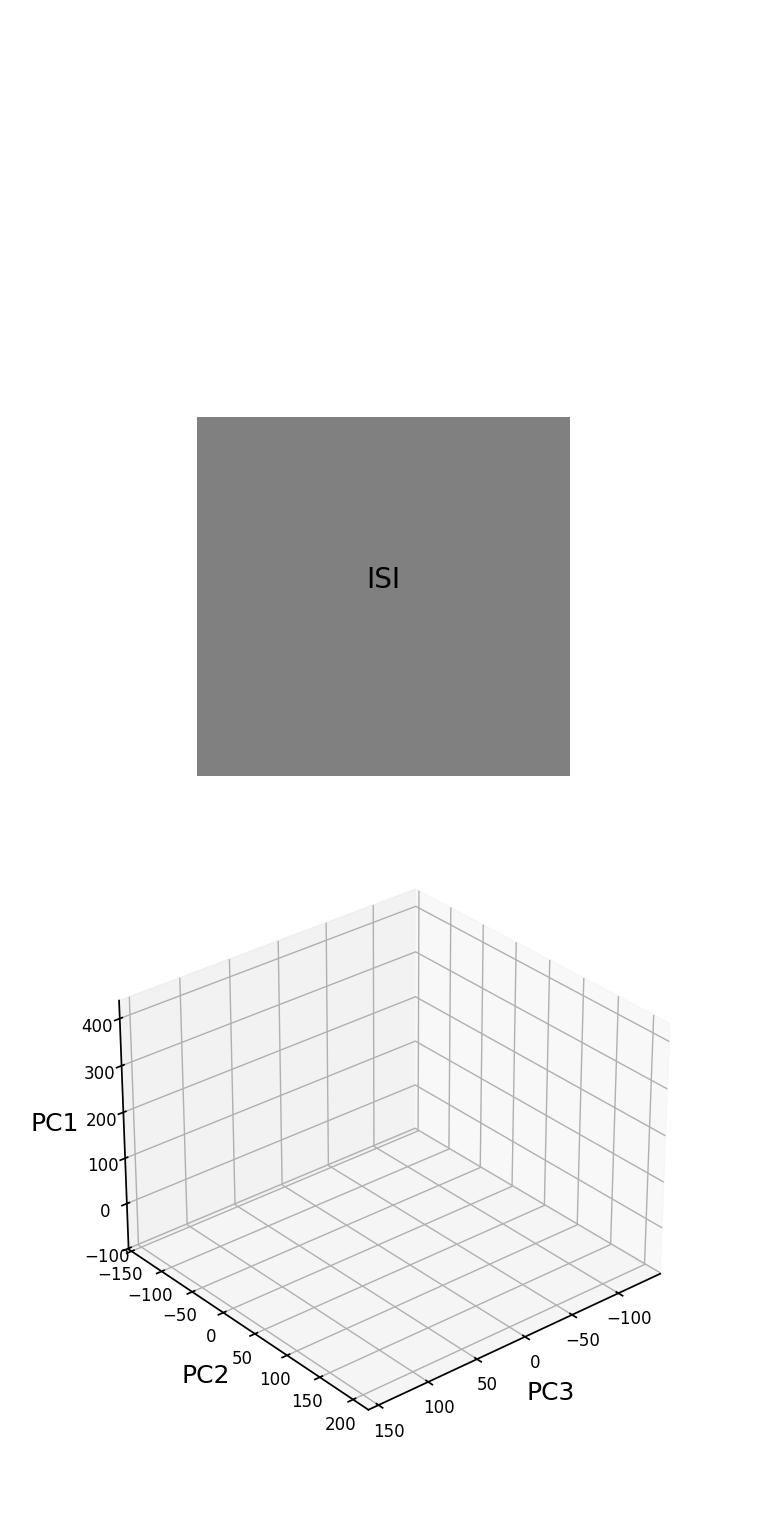

In [120]:
lp = 15
sz = 12
elev_start = 30
azim_start = 50

fig = plt.figure(figsize=(8,16))
ax1 = fig.add_subplot(2,1,1)
ax1.set_frame_on(False)

ax = fig.add_subplot(2,1,2, projection='3d')
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

# scatter plots
ff_scat = ax.scatter(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
fn_scat = ax.scatter(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], fn_responses_proj[0,pc_idx_z], c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
nf_scat = ax.scatter(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], nf_responses_proj[0,pc_idx_z], c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
nn_scat = ax.scatter(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], nn_responses_proj[0,pc_idx_z], c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')

# line plots
ff_line = ax.plot(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['ff'], alpha=a)[0]
fn_line = ax.plot(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['fn'], alpha=a)[0]
nf_line = ax.plot(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['nf'], alpha=a)[0]
nn_line = ax.plot(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], ff_responses_proj[0,pc_idx_z], c=colors['nn'], alpha=a)[0]

# rectangle
patch = patches.Rectangle((.25, 0), .5, .5, facecolor=patch_color[0], fill=True)
ax1.add_patch(patch)

# text
txt = ax1.text(.5, .3, '', fontsize=20, verticalalignment='center', horizontalalignment='center')
time_txt = ax1.text(.5, .25, '', fontsize=16, verticalalignment='center', horizontalalignment='center')

ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
# leg = ax.legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
ax1.set(xlim=(0,1), ylim=(0,1), xlabel='', ylabel='', xticks=[], yticks=[])

def update(frame):
    # update scatter plots
    ff_scat._offsets3d = ( ff_responses_proj[:frame,pc_idx_x], ff_responses_proj[:frame,pc_idx_y], ff_responses_proj[:frame,pc_idx_z] )
    fn_scat._offsets3d = ( fn_responses_proj[:frame,pc_idx_x], fn_responses_proj[:frame,pc_idx_y], fn_responses_proj[:frame,pc_idx_z] )
    nf_scat._offsets3d = ( nf_responses_proj[:frame,pc_idx_x], nf_responses_proj[:frame,pc_idx_y], nf_responses_proj[:frame,pc_idx_z] )
    nn_scat._offsets3d = ( nn_responses_proj[:frame,pc_idx_x], nn_responses_proj[:frame,pc_idx_y], nn_responses_proj[:frame,pc_idx_z] )
    
    # update line plots   
    ff_line.set_data_3d(ff_responses_proj[:frame,pc_idx_x], ff_responses_proj[:frame,pc_idx_y], ff_responses_proj[:frame,pc_idx_z])
    fn_line.set_data_3d(fn_responses_proj[:frame,pc_idx_x], fn_responses_proj[:frame,pc_idx_y], fn_responses_proj[:frame,pc_idx_z])
    nf_line.set_data_3d(nf_responses_proj[:frame,pc_idx_x], nf_responses_proj[:frame,pc_idx_y], nf_responses_proj[:frame,pc_idx_z])
    nn_line.set_data_3d(nn_responses_proj[:frame,pc_idx_x], nn_responses_proj[:frame,pc_idx_y], nn_responses_proj[:frame,pc_idx_z])

    elev = elev_start + 30 * np.sin(2 * np.pi * frame / 360)
    azim = azim_start + 360 * frame / 360  # full 360 degree rotation
    ax.view_init(elev=elev_start, azim=azim_start)
    
    # update rectangle
    patch.set_facecolor(patch_color[frame])
    
    # update text
    txt.set_text(labels[frame])
    time_txt.set_text(time_labels[frame])
    
#     # # keep legend consistent
#     leg.set_ncols(2)
#     leg.set_bbox_to_anchor((1,1))
#     leg.set_loc('upper left')

    return fig

n_frames = len(time_bins)+1
isi = 750 # in ms
ani = animation.FuncAnimation(fig=fig, func=update, frames=n_frames, interval=isi)
plt.tight_layout()
plt.subplots_adjust(hspace=-.1)

filename = f"pca_trialavg_3dproj_{session_id}_{area_of_interest}"
ani.save(fig_dir+filename+'.gif', writer="pillow")

### Top 3 PCs

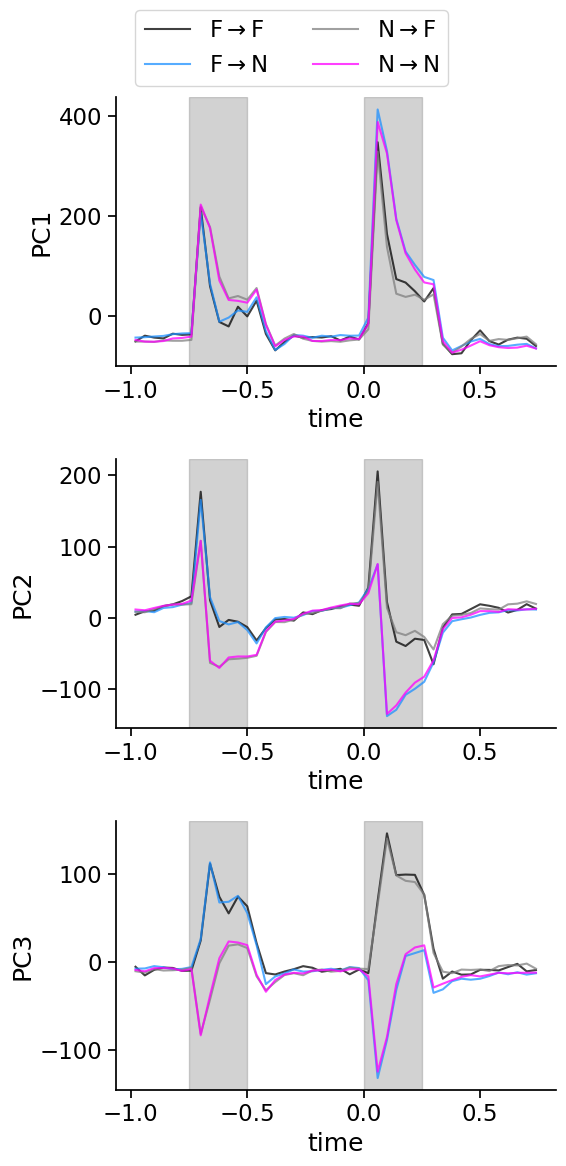

In [121]:
# plot projection onto top PCs vs. time within trial
a = .75
fig, ax = plt.subplots(3,1, figsize=(6,12))
for i in range(3):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    # shade image on periods
    ax[i].axvspan(-.75, -.5, alpha=.35, color='gray', zorder=0)
    ax[i].axvspan(0, .25, alpha=.35, color='gray', zorder=0)

for i in range(3):
    pc_idx = i
    ax[i].plot(time_bins, ff_responses_proj[:,pc_idx], colors['ff'], alpha=a, label=r'F$\rightarrow$F')
    ax[i].plot(time_bins, fn_responses_proj[:,pc_idx], colors['fn'], alpha=a, label=r'F$\rightarrow$N')
    ax[i].plot(time_bins, nf_responses_proj[:,pc_idx], colors['nf'], alpha=a, label=r'N$\rightarrow$F')
    ax[i].plot(time_bins, nn_responses_proj[:,pc_idx], colors['nn'], alpha=a, label=r'N$\rightarrow$N')
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(f'PC{i+1}')
ax[0].legend(ncol=2, bbox_to_anchor=(.4,1), loc='lower center')
plt.tight_layout()

filename = f"pca_trialavg_topPCs_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

### Heatmap of PCs

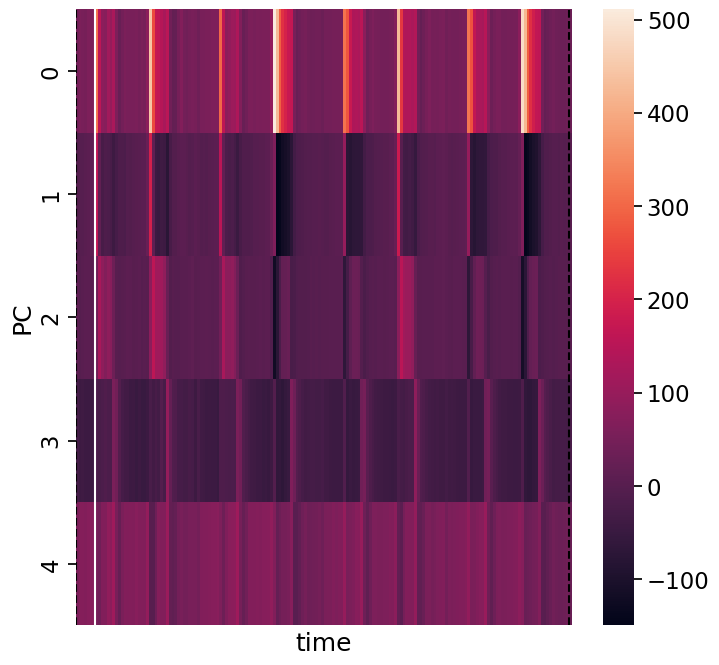

In [122]:
# heatmap of projection onto PCs vs. time (components x concatenated times)
plt.figure(figsize=(8,8))
pcs = pca.components_
sns.heatmap((pcs @ concat_responses)[:5,:])
plt.xticks([])
plt.xlabel('time')
plt.ylabel('PC')

# add lines to separate conditions
for i in range(4):
    plt.axvline(x=(t-1)*i, color='k', linestyle='--')

# add lines for image change onset 
for i in range(4):
    plt.axvline(x=7+(t-1)*i, color='w', linestyle='-') # don't hardcode
    
# label conditions
# ff_responses,fn_responses,nf_responses,nn_responses

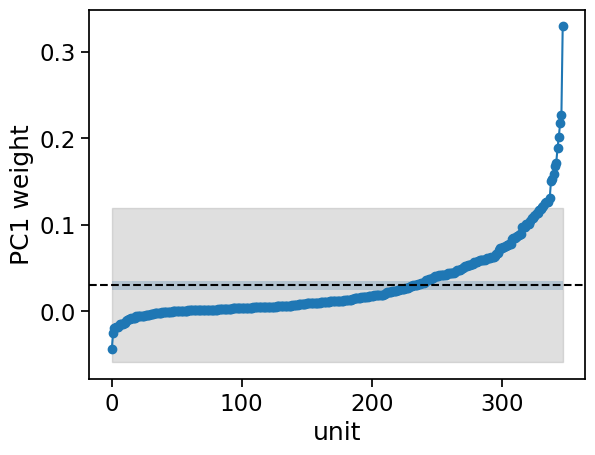

In [123]:
# plot component weights for each unit (check that there's not just a few super active units that bias the PCA)
sorted_pc = np.sort(pcs[0,:])
plt.plot(sorted_pc, 'o-')
plt.xlabel('unit')
plt.ylabel('PC1 weight')

# add CI thresholds to see which units fall outside this ( 95% CI = mu +/- 1.96*SEM = 1.96*SD/sqrt(N) )
z = 2
plt.axhline(sorted_pc.mean(), color='k', linestyle='--')
plt.fill_between(range(num_units), sorted_pc.mean() - z*sorted_pc.std()/np.sqrt(num_units), sorted_pc.mean() + z*sorted_pc.std()/np.sqrt(num_units), alpha=.25)

# add SD thresholds (95% of data falls within 2 SDs from mean)
plt.fill_between(range(num_units), sorted_pc.mean() - 2*sorted_pc.std(), sorted_pc.mean() + 2*sorted_pc.std(), color='gray', alpha=.25);

### First vs last exposure trajectories

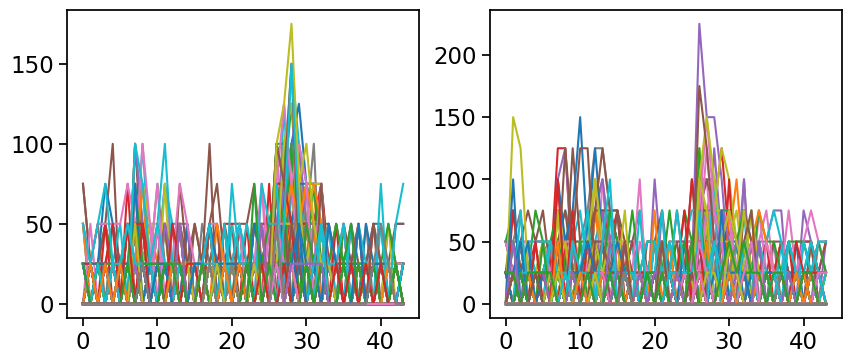

In [124]:
# get trial-averaged response to first and last image change of each condition
first_fn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, fn_idx[0], time_before, time_after, bin_size=bin_size)
last_fn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, fn_idx[-1], time_before, time_after, bin_size=bin_size)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(first_fn_responses.T)
ax[1].plot(last_fn_responses.T);

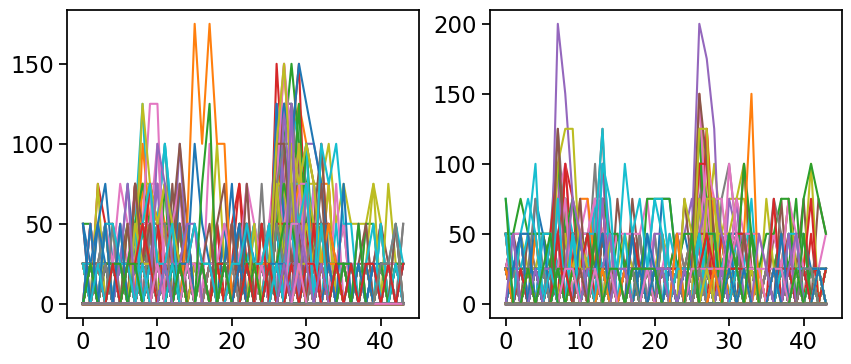

In [125]:
# get trial-averaged response to first and last image change of each condition
first_nn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, nn_idx[0], time_before, time_after, bin_size=bin_size)
last_nn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, nn_idx[-1], time_before, time_after, bin_size=bin_size)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(first_nn_responses.T)
ax[1].plot(last_nn_responses.T);

In [126]:
first_fn_responses_proj = pca.transform(first_fn_responses.T - concat_responses.T.mean(axis=0)) # input should be samples x features
last_fn_responses_proj = pca.transform(last_fn_responses.T - concat_responses.T.mean(axis=0))

first_nn_responses_proj = pca.transform(first_nn_responses.T - concat_responses.T.mean(axis=0))
last_nn_responses_proj = pca.transform(last_nn_responses.T - concat_responses.T.mean(axis=0))

#### F-->N 3d

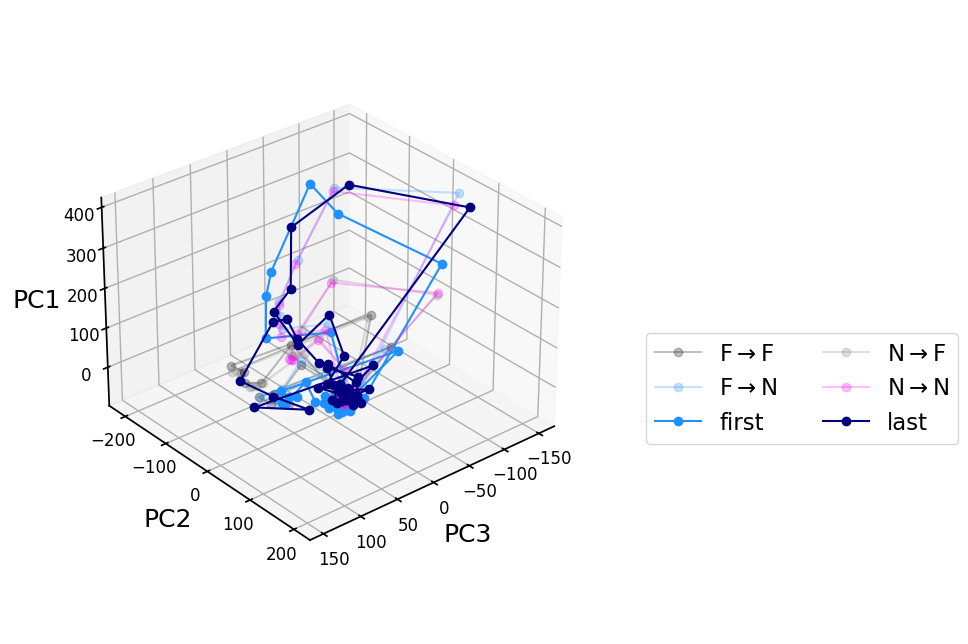

In [127]:
a = .25
m = 'o-'
lp = 15
sz = 12
elev_start = 30
azim_start = 50
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':'3d'})
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

ax.plot(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], ff_responses_proj[:,pc_idx_z], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], fn_responses_proj[:,pc_idx_z], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')

# first fn exposure
ax.plot(first_fn_responses_proj[:,pc_idx_x], first_fn_responses_proj[:,pc_idx_y], first_fn_responses_proj[:,pc_idx_z], m, c=colors['fn'], label='first')

ax.plot(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], nf_responses_proj[:,pc_idx_z], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], nn_responses_proj[:,pc_idx_z], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')

# last fn exposure
ax.plot(last_fn_responses_proj[:,pc_idx_x], last_fn_responses_proj[:,pc_idx_y], last_fn_responses_proj[:,pc_idx_z], m, c='navy', label='last')

ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
# ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
plt.legend(ncols=2, bbox_to_anchor=(1,.5), loc='upper left')
plt.tight_layout()

filename = f"pca_trialavg_3dproj_firstvlast_fn_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

#### N-->N 3d

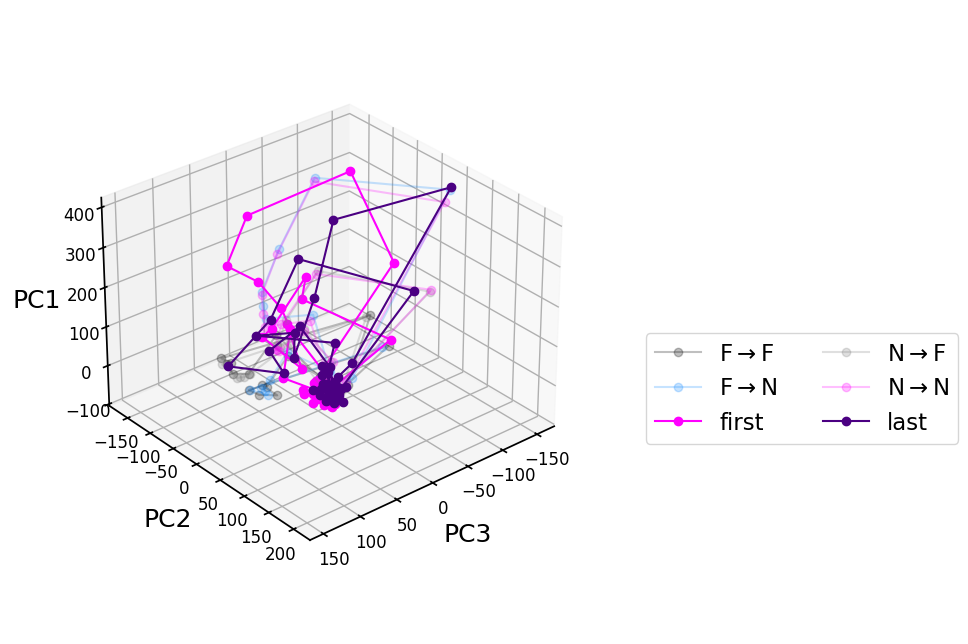

In [128]:
a = .25
m = 'o-'
lp = 15
sz = 12
elev_start = 30
azim_start = 50
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':'3d'})
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

ax.plot(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], ff_responses_proj[:,pc_idx_z], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], fn_responses_proj[:,pc_idx_z], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')

# first nn exposure
ax.plot(first_nn_responses_proj[:,pc_idx_x], first_nn_responses_proj[:,pc_idx_y], first_nn_responses_proj[:,pc_idx_z], m, c=colors['nn'], label='first')

ax.plot(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], nf_responses_proj[:,pc_idx_z], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], nn_responses_proj[:,pc_idx_z], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')

# last nn exposure
ax.plot(last_nn_responses_proj[:,pc_idx_x], last_nn_responses_proj[:,pc_idx_y], last_nn_responses_proj[:,pc_idx_z], m, c='indigo', label='last')

ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
# ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
plt.legend(ncols=2, bbox_to_anchor=(1,.5), loc='upper left')
plt.tight_layout()

filename = f"pca_trialavg_3dproj_firstvlast_nn_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

### Hit vs miss responses

In [129]:
# get indices of image change trials that are hit and miss
hit_idx = np.where(change_trial_df.hit)[0]
mis_idx = np.where(change_trial_df.miss)[0]

# get indices of each image change condition that are hit and miss
hit_ff_idx = ff_idx[np.isin(ff_idx,hit_idx)]
mis_ff_idx = ff_idx[np.isin(ff_idx,mis_idx)]
hit_fn_idx = fn_idx[np.isin(fn_idx,hit_idx)]
mis_fn_idx = fn_idx[np.isin(fn_idx,mis_idx)]
hit_nf_idx = nf_idx[np.isin(nf_idx,hit_idx)]
mis_nf_idx = nf_idx[np.isin(nf_idx,mis_idx)]
hit_nn_idx = nn_idx[np.isin(nn_idx,hit_idx)]
mis_nn_idx = nn_idx[np.isin(nn_idx,mis_idx)]

# get trial-averaged response to hit and miss trials of each image change condition
hit_ff_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, hit_ff_idx, time_before, time_after, bin_size=bin_size)
mis_ff_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, mis_ff_idx, time_before, time_after, bin_size=bin_size)
hit_fn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, hit_fn_idx, time_before, time_after, bin_size=bin_size)
mis_fn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, mis_fn_idx, time_before, time_after, bin_size=bin_size)
hit_nf_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, hit_nf_idx, time_before, time_after, bin_size=bin_size)
mis_nf_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, mis_nf_idx, time_before, time_after, bin_size=bin_size)
hit_nn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, hit_nn_idx, time_before, time_after, bin_size=bin_size)
mis_nn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, mis_nn_idx, time_before, time_after, bin_size=bin_size)

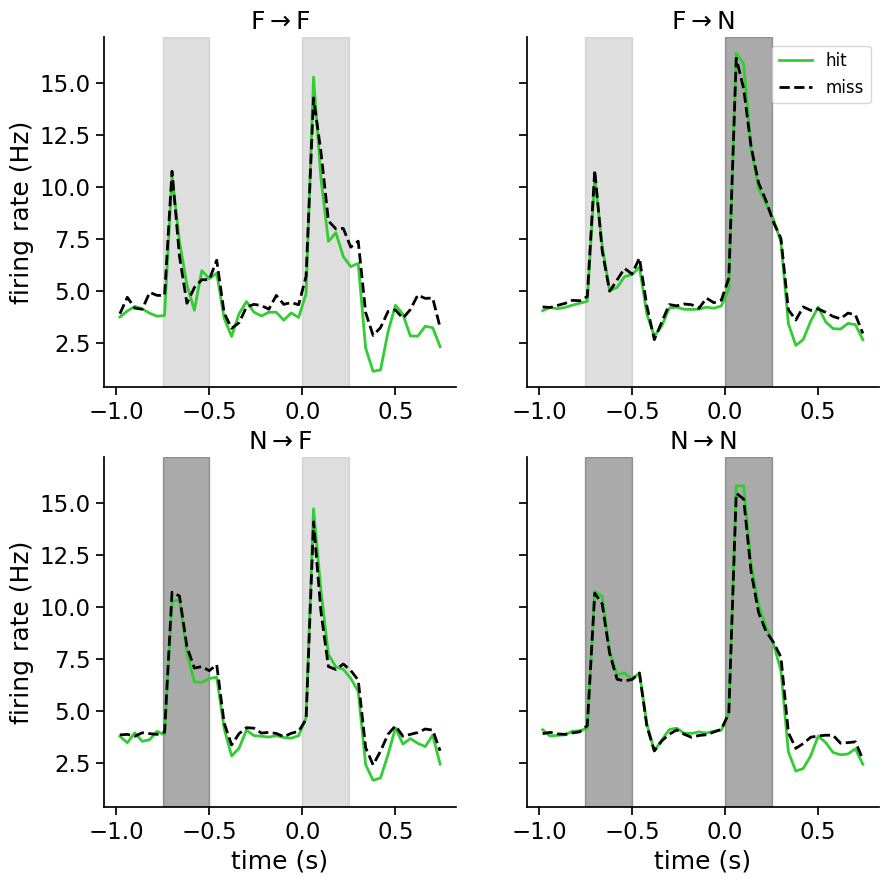

In [130]:
# plot trial-averaged unit responses to each image change condition
w_unit = .75
w_avg = 2
w_vert = 1
a = .4
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True)
for i in range(2):
    for j in range(2):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
# shade image on periods
ax[0,0].axvspan(-.75, -.5, alpha=a, color=colors['F'], zorder=0)
ax[0,1].axvspan(-.75, -.5, alpha=a, color=colors['F'], zorder=0)
ax[0,0].axvspan(0, .25, alpha=a, color=colors['F'], zorder=0)
ax[1,0].axvspan(0, .25, alpha=a, color=colors['F'], zorder=0)
ax[1,0].axvspan(-.75, -.5, alpha=a, color=colors['N'], zorder=0)
ax[1,1].axvspan(-.75, -.5, alpha=a, color=colors['N'], zorder=0)
ax[0,1].axvspan(0, .25, alpha=a, color=colors['N'], zorder=0)
ax[1,1].axvspan(0, .25, alpha=a, color=colors['N'], zorder=0)
        
time_bins = np.arange(-time_before, time_after, bin_size)+bin_size/2

ax[0,0].set_title(r'F$\rightarrow$F')
ax[0,0].plot(time_bins, hit_ff_responses.mean(axis=0), c=colors['hit'], linewidth=w_avg)
ax[0,0].plot(time_bins, mis_ff_responses.mean(axis=0), c=colors['miss'], linestyle='--', linewidth=w_avg)

ax[0,1].set_title(r'F$\rightarrow$N')
ax[0,1].plot(time_bins, hit_fn_responses.mean(axis=0), c=colors['hit'], linewidth=w_avg, label='hit')
ax[0,1].plot(time_bins, mis_fn_responses.mean(axis=0), c=colors['miss'], linestyle='--', linewidth=w_avg, label='miss')

ax[1,0].set_title(r'N$\rightarrow$F')
ax[1,0].plot(time_bins, hit_nf_responses.mean(axis=0), c=colors['hit'], linewidth=w_avg)
ax[1,0].plot(time_bins, mis_nf_responses.mean(axis=0), c=colors['miss'], linestyle='--', linewidth=w_avg)

ax[1,1].set_title(r'N$\rightarrow$N')
ax[1,1].plot(time_bins, hit_nn_responses.mean(axis=0), c=colors['hit'], linewidth=w_avg)
ax[1,1].plot(time_bins, mis_nn_responses.mean(axis=0), c=colors['miss'], linestyle='--', linewidth=w_avg)

ax[0,0].set_ylabel('firing rate (Hz)')
ax[1,0].set_ylabel('firing rate (Hz)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')
ax[0,1].legend(loc='upper right', fontsize=12)

filename = f"erp_trialavg_percondition_hitvmiss_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

### Hit vs miss trajectories

In [131]:
hit_ff_responses_proj = pca.transform(hit_ff_responses.T - concat_responses.T.mean(axis=0)) 
mis_ff_responses_proj = pca.transform(mis_ff_responses.T - concat_responses.T.mean(axis=0))

hit_fn_responses_proj = pca.transform(hit_fn_responses.T - concat_responses.T.mean(axis=0)) 
mis_fn_responses_proj = pca.transform(mis_fn_responses.T - concat_responses.T.mean(axis=0))

hit_nf_responses_proj = pca.transform(hit_nf_responses.T - concat_responses.T.mean(axis=0)) 
mis_nf_responses_proj = pca.transform(mis_nf_responses.T - concat_responses.T.mean(axis=0))

hit_nn_responses_proj = pca.transform(hit_nn_responses.T - concat_responses.T.mean(axis=0)) 
mis_nn_responses_proj = pca.transform(mis_nn_responses.T - concat_responses.T.mean(axis=0))

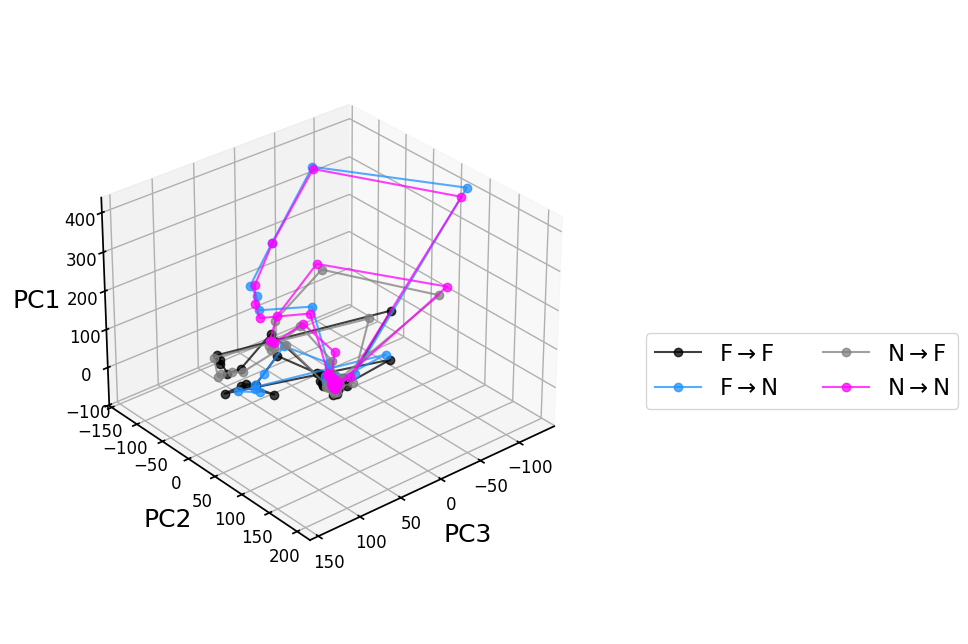

In [132]:
a = .75
m = 'o-'
lp = 15
sz = 12
elev_start = 30
azim_start = 50
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':'3d'})
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

ax.plot(hit_ff_responses_proj[:,pc_idx_x], hit_ff_responses_proj[:,pc_idx_y], hit_ff_responses_proj[:,pc_idx_z], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(hit_fn_responses_proj[:,pc_idx_x], hit_fn_responses_proj[:,pc_idx_y], hit_fn_responses_proj[:,pc_idx_z], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
ax.plot(hit_nf_responses_proj[:,pc_idx_x], hit_nf_responses_proj[:,pc_idx_y], hit_nf_responses_proj[:,pc_idx_z], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(hit_nn_responses_proj[:,pc_idx_x], hit_nn_responses_proj[:,pc_idx_y], hit_nn_responses_proj[:,pc_idx_z], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')
ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
plt.legend(ncols=2, bbox_to_anchor=(1,.5), loc='upper left')
plt.tight_layout()

filename = f"pca_trialavg_3dproj_hit_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

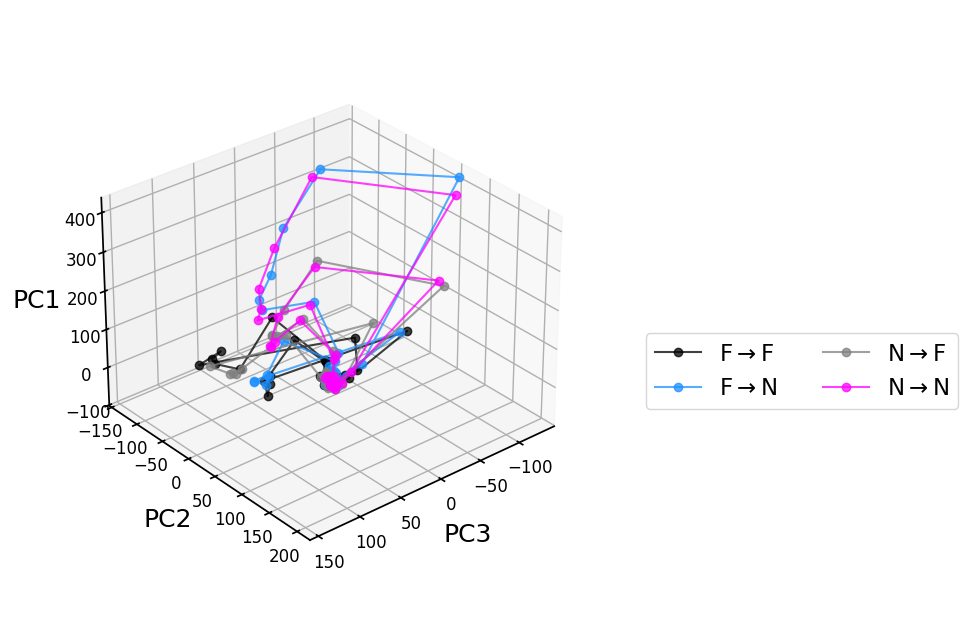

In [133]:
a = .75
m = 'o-'
lp = 15
sz = 12
elev_start = 30
azim_start = 50
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':'3d'})
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.set_box_aspect(aspect=None, zoom=0.8)
pc_idx_x = 2
pc_idx_y = 1
pc_idx_z = 0

ax.plot(mis_ff_responses_proj[:,pc_idx_x], mis_ff_responses_proj[:,pc_idx_y], mis_ff_responses_proj[:,pc_idx_z], m, c=colors['ff'], alpha=a, label=r'F$\rightarrow$F')
ax.plot(mis_fn_responses_proj[:,pc_idx_x], mis_fn_responses_proj[:,pc_idx_y], mis_fn_responses_proj[:,pc_idx_z], m, c=colors['fn'], alpha=a, label=r'F$\rightarrow$N')
ax.plot(mis_nf_responses_proj[:,pc_idx_x], mis_nf_responses_proj[:,pc_idx_y], mis_nf_responses_proj[:,pc_idx_z], m, c=colors['nf'], alpha=a, label=r'N$\rightarrow$F')
ax.plot(mis_nn_responses_proj[:,pc_idx_x], mis_nn_responses_proj[:,pc_idx_y], mis_nn_responses_proj[:,pc_idx_z], m, c=colors['nn'], alpha=a, label=r'N$\rightarrow$N')
ax.view_init(elev=elev_start, azim=azim_start)
ax.set(xlim=ax_lims[pc_idx_x], ylim=ax_lims[pc_idx_y], zlim=ax_lims[pc_idx_z], xlabel=f'PC{pc_idx_x+1}', ylabel=f'PC{pc_idx_y+1}', zlabel=f'PC{pc_idx_z+1}')
plt.legend(ncols=2, bbox_to_anchor=(1,.5), loc='upper left')
plt.tight_layout()

filename = f"pca_trialavg_3dproj_mis_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

## VIP vs other units

### Loadings

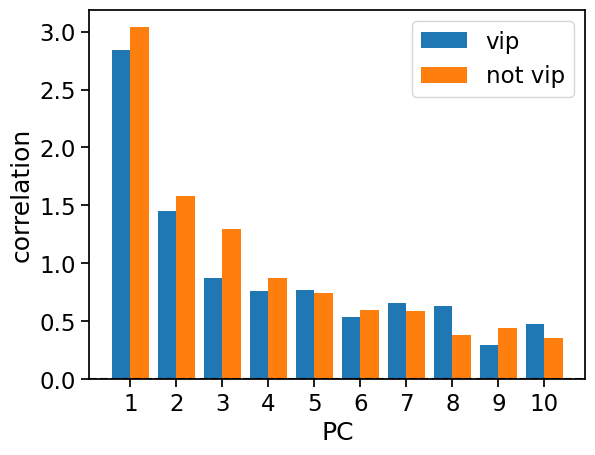

In [134]:
# find the PC loadings (each entry of the matrix contains the correlation between the original feature and the PC) 
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

num_pcs = 10
w = .5
sp = 1.25
plt.bar(np.arange(0,num_pcs)*sp-w/2, abs(loadings[is_vip,:num_pcs]).mean(axis=0), width=w, label='vip')
plt.bar(np.arange(0,num_pcs)*sp+w/2, abs(loadings[~is_vip,:num_pcs]).mean(axis=0), width=w, label='not vip')
plt.axhline(0, color='k', linestyle='--')

plt.xticks(np.arange(0,num_pcs)*sp, np.arange(1,num_pcs+1))
plt.xlabel('PC')
plt.ylabel('correlation')
plt.legend();

### Response by condition

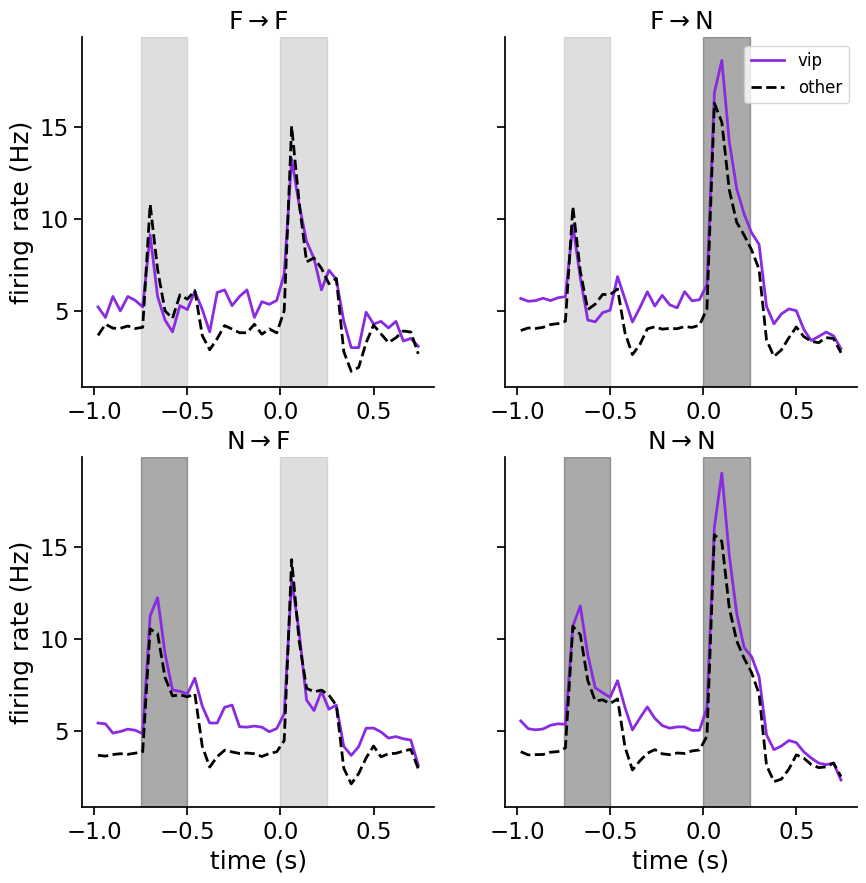

In [135]:
# plot trial-averaged unit responses to each image change condition
w_unit = .75
w_avg = 2
w_vert = 1
a = .4
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True)
for i in range(2):
    for j in range(2):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
# shade image on periods
ax[0,0].axvspan(-.75, -.5, alpha=a, color=colors['F'], zorder=0)
ax[0,1].axvspan(-.75, -.5, alpha=a, color=colors['F'], zorder=0)
ax[0,0].axvspan(0, .25, alpha=a, color=colors['F'], zorder=0)
ax[1,0].axvspan(0, .25, alpha=a, color=colors['F'], zorder=0)
ax[1,0].axvspan(-.75, -.5, alpha=a, color=colors['N'], zorder=0)
ax[1,1].axvspan(-.75, -.5, alpha=a, color=colors['N'], zorder=0)
ax[0,1].axvspan(0, .25, alpha=a, color=colors['N'], zorder=0)
ax[1,1].axvspan(0, .25, alpha=a, color=colors['N'], zorder=0)
        
time_bins = np.arange(-time_before, time_after, bin_size)+bin_size/2

ax[0,0].set_title(r'F$\rightarrow$F')
ax[0,0].plot(time_bins, ff_responses[is_vip,:].mean(axis=0), c=colors['vip'], linewidth=w_avg)
ax[0,0].plot(time_bins, ff_responses[~is_vip,:].mean(axis=0), c=colors['non'], linestyle='--', linewidth=w_avg)

ax[0,1].set_title(r'F$\rightarrow$N')
ax[0,1].plot(time_bins, fn_responses[is_vip,:].mean(axis=0), c=colors['vip'], linewidth=w_avg, label='vip')
ax[0,1].plot(time_bins, fn_responses[~is_vip,:].mean(axis=0), c=colors['non'], linestyle='--', linewidth=w_avg, label='other')

ax[1,0].set_title(r'N$\rightarrow$F')
ax[1,0].plot(time_bins, nf_responses[is_vip,:].mean(axis=0), c=colors['vip'], linewidth=w_avg)
ax[1,0].plot(time_bins, nf_responses[~is_vip,:].mean(axis=0), c=colors['non'], linestyle='--', linewidth=w_avg)

ax[1,1].set_title(r'N$\rightarrow$N')
ax[1,1].plot(time_bins, nn_responses[is_vip,:].mean(axis=0), c=colors['vip'], linewidth=w_avg)
ax[1,1].plot(time_bins, nn_responses[~is_vip,:].mean(axis=0), c=colors['non'], linestyle='--', linewidth=w_avg)

ax[0,0].set_ylabel('firing rate (Hz)')
ax[1,0].set_ylabel('firing rate (Hz)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)');
ax[0,1].legend(loc='upper right', fontsize=12)

filename = f"erp_trialavg_percondition_vipvnot_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

### Correlation with PCs

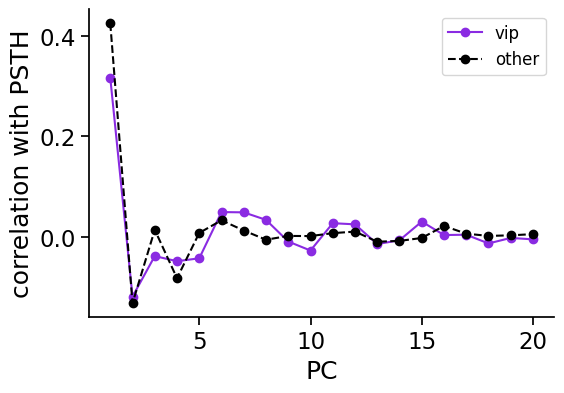

In [136]:
num_pcs = 20
vip_corr = np.zeros((num_pcs,))
non_corr = np.zeros((num_pcs,))
for pc_idx in range(num_pcs):
    corr = []
    for i in range(is_vip.sum()):
        corr.append(np.corrcoef(concat_responses[is_vip,:][i], concat_responses_proj[:,pc_idx])[0,1])
    vip_corr[pc_idx] = np.mean(corr)
    
    corr = []
    for i in range((is_vip==False).sum()):
        corr.append(np.corrcoef(concat_responses[~is_vip,:][i], concat_responses_proj[:,pc_idx])[0,1])
    non_corr[pc_idx] = np.mean(corr)
    
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(range(1,num_pcs+1), vip_corr, 'o-', color=colors['vip'], label='vip')
plt.plot(range(1,num_pcs+1), non_corr, 'o--', color=colors['non'], label='other')
plt.xlabel('PC')
plt.ylabel('correlation with PSTH')
plt.legend(fontsize=12);

filename = f"pca_trialavg_componentcorr_vipvnot_{session_id}_{area_of_interest}"
plt.savefig(fig_dir+filename+'.svg')

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


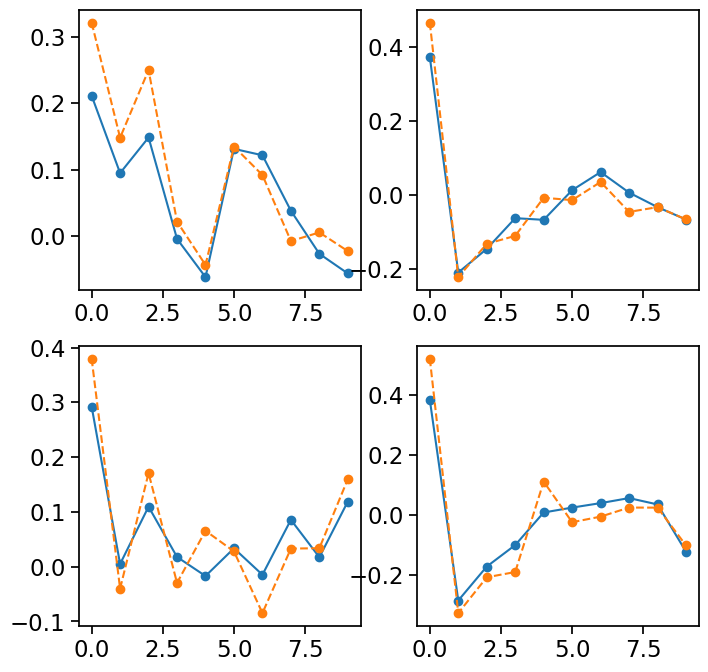

In [137]:
num_pcs = 10
vip_corr = np.zeros((4,num_pcs))
non_corr = np.zeros((4,num_pcs))
for pc_idx in range(num_pcs):
    for j,(responses,responses_proj) in enumerate(zip([ff_responses,fn_responses,nf_responses,nn_responses],[ff_responses_proj,fn_responses_proj,nf_responses_proj,nn_responses_proj])):
        corr = []
        for i in range(is_vip.sum()):
            corr.append(np.corrcoef(responses[is_vip,:][i], responses_proj[:,pc_idx])[0,1])
        vip_corr[j,pc_idx] = np.nanmean(corr)
                        
    for j,(responses,responses_proj) in enumerate(zip([ff_responses,fn_responses,nf_responses,nn_responses],[ff_responses_proj,fn_responses_proj,nf_responses_proj,nn_responses_proj])):
        corr = []
        for i in range((is_vip==False).sum()):
            corr.append(np.corrcoef(responses[~is_vip,:][i], responses_proj[:,pc_idx])[0,1]) # will be nan if the responses are all 0s
        non_corr[j,pc_idx] = np.nanmean(corr)

fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].plot(vip_corr[0,:], 'o-')
ax[0,0].plot(non_corr[0,:], 'o--')

ax[0,1].plot(vip_corr[1,:], 'o-')
ax[0,1].plot(non_corr[1,:], 'o--')

ax[1,0].plot(vip_corr[2,:], 'o-')
ax[1,0].plot(non_corr[2,:], 'o--')

ax[1,1].plot(vip_corr[3,:], 'o-')
ax[1,1].plot(non_corr[3,:], 'o--');